In [1]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
#from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import *
import os 
# Tell GDAL to throw Python exceptions, and register all drivers
#gdal.UseExceptions()
#gdal.AllRegister()
import rasterio

In [2]:
import multiprocessing as mp    

In [3]:
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

In [4]:
def visRGB(img1, img2, img3,
           title = 'RGB image',
           scale1 = [],
           scale2 = [],
           scale3 = [],
           flag = 0, outall = ''):
    """
    Visualise the RGB of a single acquisition
    """           
    if scale1 == []:
       scale1 = img1
    if scale2 == []:
       scale2 = img2
    if scale3 == []:
       scale3 = img3

    size = np.shape(img1)           
    iRGB = np.zeros([size[0],size[1],3])
    iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
    iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
    iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
    iRGB[np.abs(iRGB) > 1] = 1
            
#    plt.figure()

    fig = plt.figure(figsize=(8,8))
    ax2 = fig.add_subplot(1,1,1)
    plot = plt.imshow(iRGB); 
    plt.title('(RGB image)'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

    if flag == 1:
        fig.savefig(outall)

    return       
           

In [5]:
# next setup a colormap for our map
colors = dict((
    (0, (255, 255, 255, 255)),   # White - NO Data
    (1, (0,0,255, 255)),      # Blue - Water
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

n=5
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

In [6]:
def read_band_image(path,dronedata):
    """
    This function takes as input the ldrone image and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   drone          drone image
             path           string            path ,of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    import os
    import rasterio

    
    os.chdir(path)
    os.getcwd()
    img_ds=rasterio.open(dronedata)
    data = np.zeros((img_ds.height, img_ds.width, img_ds.count))
                   

    for b in range(data.shape[2]):
        data[:, :, b] = np.array(img_ds.read(b+1))
    crs=img_ds.crs
    
    geoTransform = img_ds.transform
    return data, crs, geoTransform

In [8]:
# Read in our image and ROI image


datadirectory='/space/vak/Weedwatch/Patancheru/Drone/'

#GTfile='GT/GT_28Jan2021_PatanCheru_AOI_50cm.tif'
GTfile='GT/GT_15Feb2021_PatanCheru_AOI.tif'
#GTfile='GT_26Mar2021_PatanCheru_AOI_50cm.tif'

#imagefile='Images/Orthomosaic_28Jan2021_PatanCheru_AOI_50cm.tif'
imagefile='Images/Orthomosaic_15Feb2021_PatanCheru_AOI_8bit.tif'
#imagefile='Orthomosaic_26Mar2021_PatanCheru_AOI_50cm.tif'

os.chdir(datadirectory)
os.getcwd()

# Read drone bands 
(dronedata1, crs1, geoTransform1) = read_band_image(datadirectory,imagefile)
(cls1,crs1, geoTransform1) = read_band_image(datadirectory,GTfile)

dronedata1=np.uint8(dronedata1)
cls1=np.uint8(cls1)
mask1=dronedata1[:,:,5]

#img_ds = gdal.Open(imagefile, gdal.GA_ReadOnly)
#roi_ds = gdal.Open(GTfile, gdal.GA_ReadOnly)

#img1 = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
 #              gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

#for b in range(img1.shape[2]):
 #   img1[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

#where_are_NaNs = isnan(img1)
#img1[where_are_NaNs] = 0

#proj=img_ds.GetProjection()

    
  

    

    
    
#GT1= roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8) #Ground truth

#for Jan and Feb data 
#mask1=np.array(img1[:,:,5])



#for march data
#mask=np.array(img>0)
#mask=mask[:,:,0]
#mask1=mask1.astype('uint8')

#for jan and mar#ch data
#GT1[mask1==0] = 0



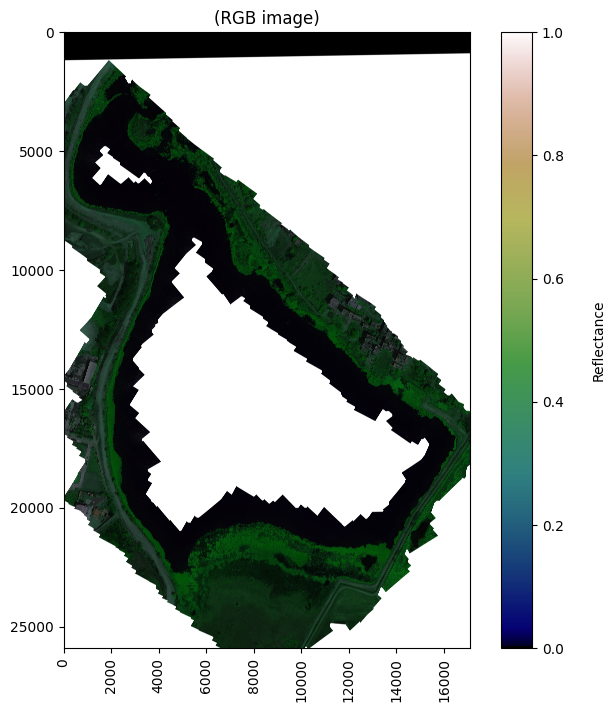

In [9]:
visRGB(dronedata1[:,:,0], dronedata1[:,:,4], dronedata1[:,:,1],
           title = 'RGB image',
           scale1 = [0,255],
           scale2 = [0,255],
           scale3 = [0,255],
           flag = 0, outall = '')

In [10]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
#n_samples = (roi > 0).sum()


n_samples = (cls1 > 0).sum()

print('We have {n} samples'.format(n=n_samples))
# What are our classification labels?
#labels = np.unique(roi[roi > 0])
labels = np.unique(cls1[cls1 > 0])

print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X1 = dronedata1[np.squeeze(cls1) > 0, :5]
cls1=np.squeeze(cls1)
y1 = cls1[cls1 > 0]

print('Our X matrix is sized: {sz}'.format(sz=X1.shape))
print('Our y array is sized: {sz}'.format(sz=y1.shape))


We have 73110060 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (73110060, 5)
Our y array is sized: (73110060,)


Text(0.5, 1.0, 'Training Data')

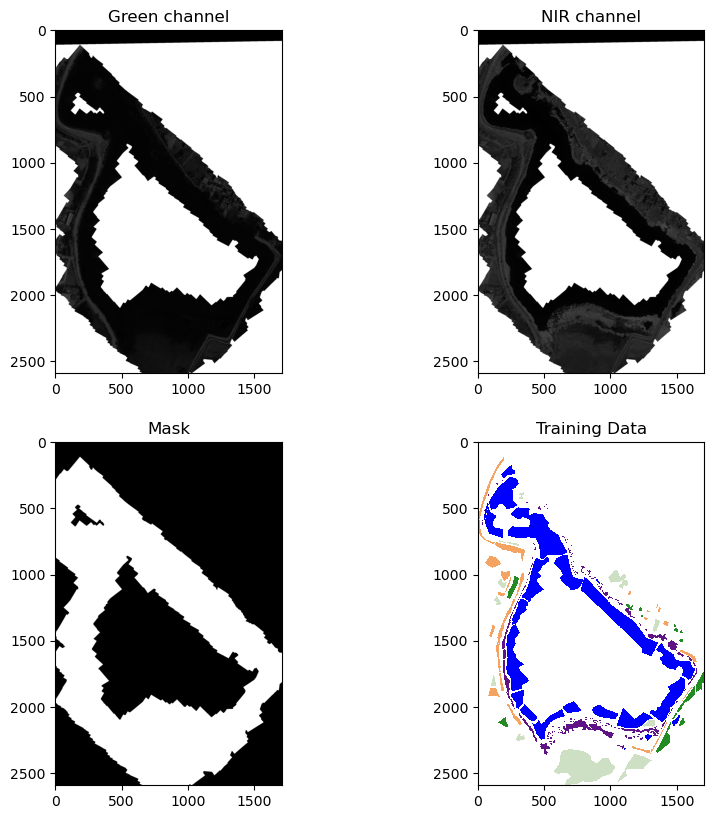

In [37]:
# Read in our image and ROI image


datadirectory='/space/vak/Weedwatch/Patancheru/Drone'

GTfile='GT_15Feb2021_PatanCheru_AOI_50cm.tif'
#GTfile='GT_26Mar2021_PatanCheru_AOI_50cm.tif'

imagefile='Orthomosaic_15Feb2021_PatanCheru_AOI_50cm.tif'
#imagefile='Orthomosaic_28Jan2021_PatanCheru_AOI_50cm.tif'
#imagefile='Orthomosaic_26Mar2021_PatanCheru_AOI_50cm.tif'

os.chdir(datadirectory)
os.getcwd()

img_ds = gdal.Open(imagefile, gdal.GA_ReadOnly)
roi_ds = gdal.Open(GTfile, gdal.GA_ReadOnly)

img2 = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img2.shape[2]):
    img2[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

where_are_NaNs = isnan(img2)
img2[where_are_NaNs] = 0

proj=img_ds.GetProjection()

    



GT2= roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8) #Ground truth

#for Jan and Feb data 
mask2=np.array(img2[:,:,5])



#for march data
#mask=np.array(img>0)
#mask=mask[:,:,0]
mask2=mask2.astype('uint8')

#for jan and march data
#GT[mask==0] = 0

f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)


ax1.imshow(img2[:, :, 2],cmap=plt.cm.gray)
ax1.set_title('Green channel')
ax2.imshow(img2[:, :, 4],cmap=plt.cm.gray)#updated forest resource map
ax2.set_title('NIR channel')
ax3.imshow(mask2,cmap=plt.cm.gray)
ax3.set_title('Mask')
ax4.imshow(GT2,  cmap=cmap, interpolation='none')#updated forest resource map
ax4.set_title('Training Data')


In [38]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
#n_samples = (roi > 0).sum()


n_samples = (GT2 > 0).sum()

print('We have {n} samples'.format(n=n_samples))
# What are our classification labels?
#labels = np.unique(roi[roi > 0])
labels = np.unique(GT2[GT2 > 0])

print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X2= img2[GT2 > 0, :5]
y2 = GT2[GT2 > 0]

print('Our X matrix is sized: {sz}'.format(sz=X2.shape))
print('Our y array is sized: {sz}'.format(sz=y2.shape))


We have 731181 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (731181, 5)
Our y array is sized: (731181,)


Text(0.5, 1.0, 'Training Data')

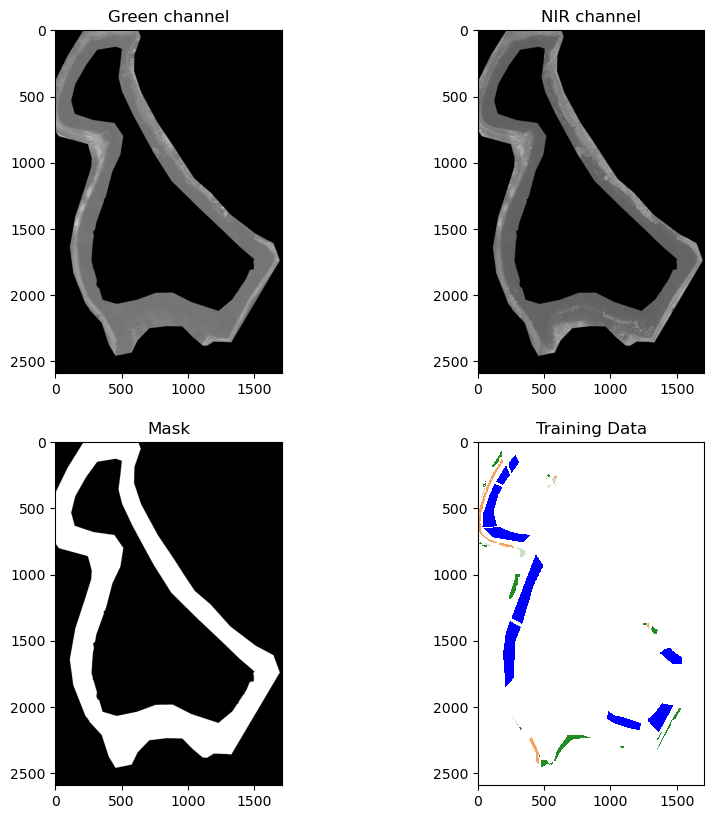

In [39]:
# Read in our image and ROI image


datadirectory='/space/vak/Weedwatch/Patancheru/Drone'

#GTfile='GT_15Feb2021_PatanCheru_AOI_50cm.tif'
GTfile='GT_26Mar2021_PatanCheru_AOI_50cm.tif'

#imagefile='Orthomosaic_15Feb2021_PatanCheru_AOI_50cm.tif'
#imagefile='Orthomosaic_28Jan2021_PatanCheru_AOI_50cm.tif'
imagefile='Orthomosaic_26Mar2021_PatanCheru_AOI_50cm.tif'

os.chdir(datadirectory)
os.getcwd()

img_ds = gdal.Open(imagefile, gdal.GA_ReadOnly)
roi_ds = gdal.Open(GTfile, gdal.GA_ReadOnly)

img3 = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img3.shape[2]):
    img3[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

where_are_NaNs = isnan(img3)
img3[where_are_NaNs] = 0

proj=img_ds.GetProjection()

    



GT3= roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8) #Ground truth

#for Jan and Feb data 
#mask3=np.array(img3[:,:,5])



#for march data
mask3=np.array(img3>0)
mask3=mask3[:,:,0]
mask3=mask3.astype('uint8')

#for jan and march data
GT3[mask3==0] = 0

f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)


ax1.imshow(img3[:, :, 2],cmap=plt.cm.gray)
ax1.set_title('Green channel')
ax2.imshow(img3[:, :, 4],cmap=plt.cm.gray)#updated forest resource map
ax2.set_title('NIR channel')
ax3.imshow(mask3,cmap=plt.cm.gray)
ax3.set_title('Mask')
ax4.imshow(GT3,  cmap=cmap, interpolation='none')#updated forest resource map
ax4.set_title('Training Data')


In [40]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
#n_samples = (roi > 0).sum()


n_samples = (GT3 > 0).sum()

print('We have {n} samples'.format(n=n_samples))
# What are our classification labels?
#labels = np.unique(roi[roi > 0])
labels = np.unique(GT3[GT3 > 0])

print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X3= img3[GT3 > 0, :5]
y3 = GT3[GT3 > 0]

print('Our X matrix is sized: {sz}'.format(sz=X3.shape))
print('Our y array is sized: {sz}'.format(sz=y3.shape))


We have 233090 samples
The training data include 4 classes: [1 3 4 5]
Our X matrix is sized: (233090, 5)
Our y array is sized: (233090,)


In [12]:
X=np.concatenate((X1,X2,X3), axis=0)
y=np.concatenate((y1,y2,y3), axis=0)

In [37]:
X=X1
y=y1

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.75, random_state=0 )

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

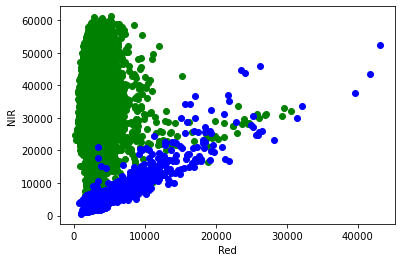

In [17]:
# Scatterplot - Color Change

# Plot
plt.scatter(X1[y1==2,2],X1[y1==2,4],color='green')
plt.scatter(X1[y1==1,2],X1[y1==1,4],color='blue')

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.xlabel("Red")
plt.ylabel("NIR")
plt.show()

In [40]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict



classifier='RF'
if classifier=='RF':
    rf = RandomForestClassifier(n_estimators=100,max_depth=7, oob_score=True,n_jobs=mp.cpu_count())
elif classifier=='DT':
    rf = ExtraTreesClassifier(max_depth=100)
elif classifier=='kNN':
    rf = KNeighborsClassifier(n_neighbors=5)
elif classifier=='GB':
    rf =GradientBoostingClassifier(n_estimators = 1000)
elif classifier=='GNB':
    rf=GaussianNB()
elif classifier=='SVM':
    rf = svm.SVC()
    


  
 
# Fit our model to training data
rf = rf.fit(X_train, y_train)



In [41]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 96.34418026739412%


In [42]:
bands = [1, 2, 3,4,5,6]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.0976970534074859
Band 2 importance: 0.18855729443006145
Band 3 importance: 0.1708189222569266
Band 4 importance: 0.20442114751722176
Band 5 importance: 0.33850558238830436


In [43]:
# Define the plotting function
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [44]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y_test
y_pred = rf.predict(X_test)

df['predict']=y_pred

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict         1        2        3        4        5       All
truth                                                          
1        32701030     1015    70086    30925    18765  32821821
2            1948  4957120       96     9069   348199   5316432
3           18510        3  4951958   257323     1619   5229413
4          237812      347    83968  8546815   128632   8997574
5            4963   536081      195   258168  1667898   2467305
All      32964263  5494566  5106303  9102300  2165113  54832545


In [45]:
# Misc
import pickle
import sys
import os
import datetime
import itertools
#from tqdm import tqdm_notebook as tqdm
import enum
import matplotlib as mpl
from sklearn import preprocessing


In [46]:
class LULC(enum.Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  ' W','xkcd:lime')
    FOREST             = (2,  ' WH',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'BU',          'orange')
    SHRUBLAND          = (4,  'BG',          'xkcd:tan')
    WATER              = (5,  'LV',              'xkcd:azure')
       
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3   
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 5, 1), lulc_cmap.N)

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
class_labels = np.unique(y_test)
class_names = [entry.class_name for entry in LULC]

In [48]:
# Define the plotting function
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

/tmp/ipykernel_103731/4049045798.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)


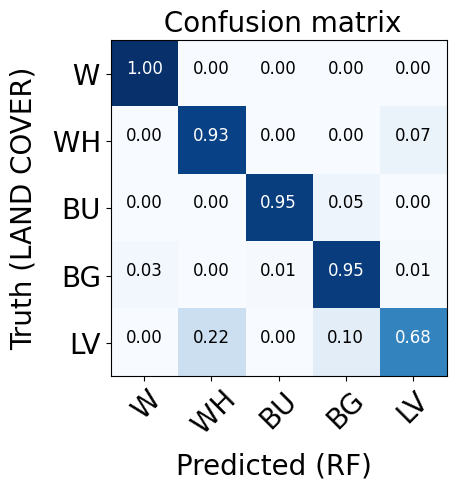

In [49]:
from sklearn import metrics
class_labels = np.unique(y_test)
class_names = [entry.class_name for entry in LULC]
fig = plt.figure(figsize=(5,5))


conf_matrix_gbm = metrics.confusion_matrix( y_test,y_pred)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (RF) ',
                      title=' Confusion matrix');

plt.tight_layout()

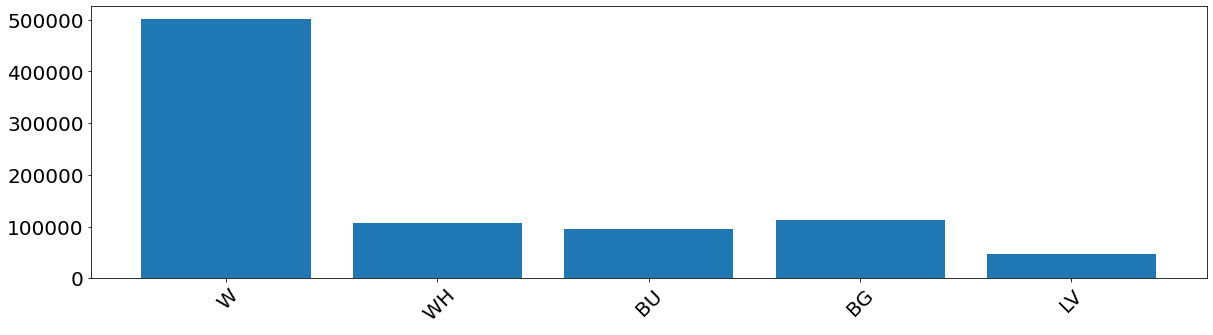

In [305]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(y_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

In [ ]:
# Take our full image,  and reshape into long 2d array (nrow * ncol, nband) for classification
img2 = dronedata1[:,:,:5]   

new_shape = (img2.shape[0] * img2.shape[1], img2.shape[2])

img_as_array = img2.reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img2.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

Reshaped from (25907, 17101, 5) to (443035607, 5)


In [272]:
# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

In [307]:
from sklearn.metrics import cohen_kappa_score

print('Kappa coeff. {:.3f}'.format( cohen_kappa_score(y_pred, y_test)))

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(y_test, y_pred)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(y_test, y_pred, average='weighted')))

Kappa coeff. 0.948
Classification accuracy 96.8%
Classification F1-score 96.8%


In [308]:
f1_scores = metrics.f1_score(y_test, y_pred, labels=class_labels, average=None)
recall = metrics.recall_score(y_test, y_pred, labels=class_labels, average=None)
precision = metrics.precision_score(y_test, y_pred, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         *  W                   = 99.6 |  99.8  | 99.4
         *  WH                  = 95.5 |  95.5  | 95.4
         * BU                   = 96.9 |  97.4  | 96.4
         * BG                   = 92.9 |  92.9  | 92.8
         * LV                   = 79.1 |  76.6  | 81.8


In [309]:
class_labels = np.unique(np.hstack([y_test, y_train]))

scores_test = rf.predict_proba(X_test)
labels_binarized = preprocessing.label_binarize(y_test, classes=class_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

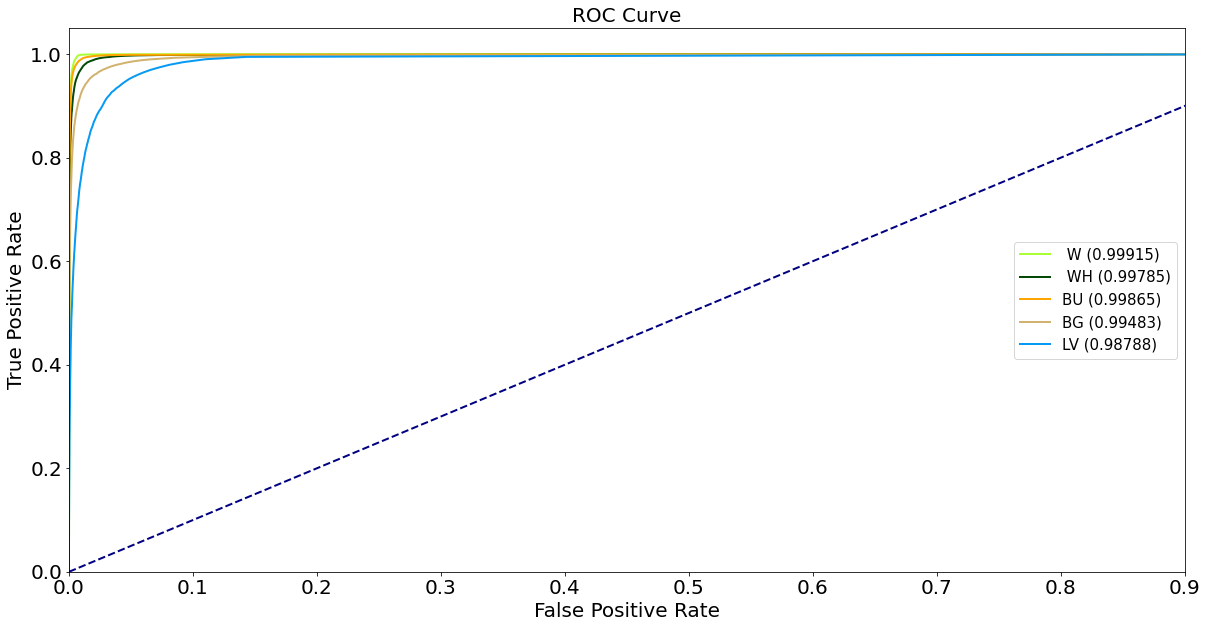

In [310]:
plt.figure(figsize=(20, 10))

for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx], color=lulc_cmap.colors[lbl],
         lw=2, label=class_names[lbl] + ' (%0.5f)' % roc_auc[idx])
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.9])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="center right", prop={'size': 15})
plt.show()

In [178]:
# First setup a 3-2-1 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img123 = color_stretch(img, [2, 1, 0], (0, 8000))


Text(0.5, 1.0, 'Training Data')

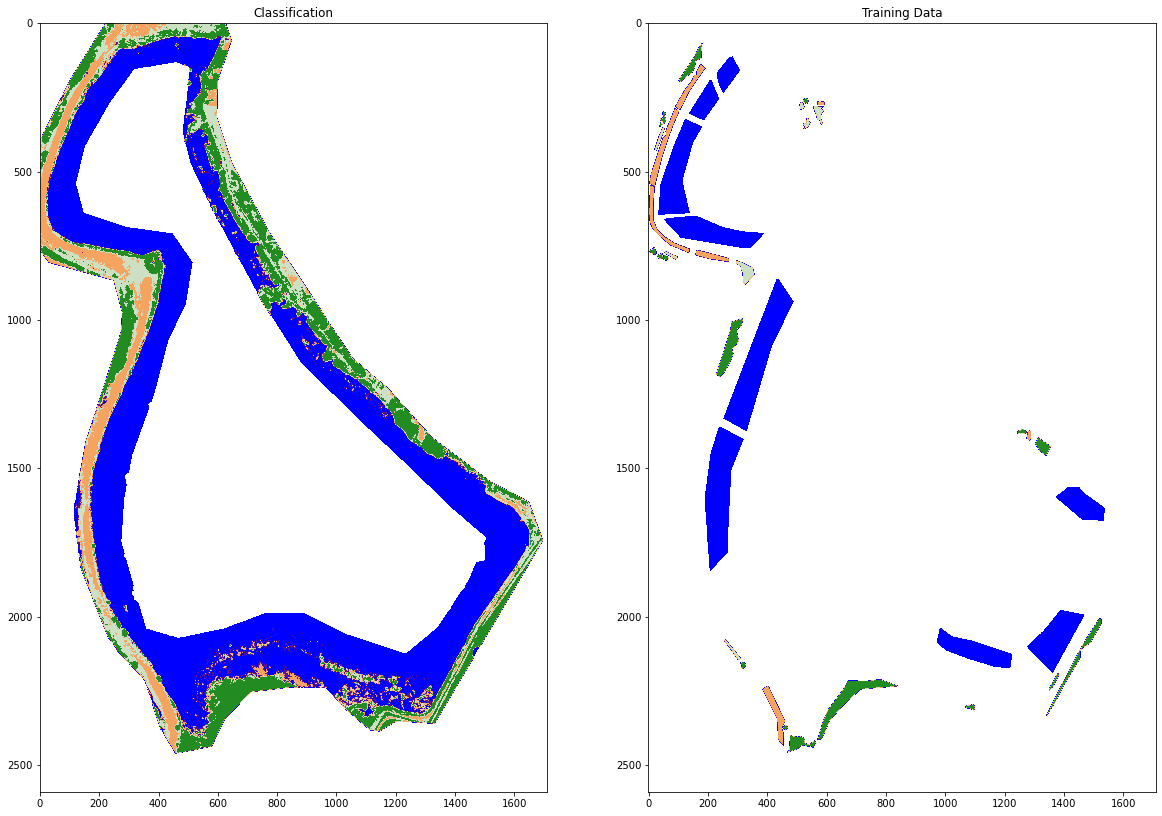

In [179]:
# Visualize


# See https://github.com/matplotlib/matplotlib/issues/844/
#n = class_prediction.max()
n = class_prediction.max()
#class_prediction[class_prediction == 2] = 1
#class_prediction[class_prediction == 3] = 2
#class_prediction[class_prediction == 4] = 2
#class_prediction[class_prediction == 5] = 3
#class_prediction[img[:,:,0] == 0] = 0
#where_are_NaNs = isnan(coh)
#class_prediction[where_are_NaNs] = 0
class_prediction[mask==0]=0

# Now show the classmap next to the image
f = plt.figure(figsize=(20,25))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax1.imshow(class_prediction,cmap=cmap)
ax1.set_title('Classification')
ax2.imshow(GT, cmap=cmap)
ax2.set_title('Training Data')


In [180]:
proj=img_ds.GetProjection()
geotrans=list(img_ds .GetGeoTransform())
bandnames=['28Jan2021_WHmap']
imagename=GTfile.replace('.tif','_Classification.tif')
CreateGeoTiff(imagename, class_prediction,gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)

'GT_26Mar2021_PatanCheru_AOI_50cm_Classification.tif'